=== Phase 3: Learning Dynamics Check (N-Dimensional) ===
Device: cuda
Testing with N = 8 (Input dim for SPRC: 49)
Step   | Sinkhorn Loss   | Proposal Loss  
---------------------------------------------
0      | 1.661609          | 1.661783
50     | 1.050954          | 1.052194
100    | 0.081409          | 0.104419
150    | 0.014086          | 0.015423
200    | 0.009392          | 0.009546
250    | 0.008364          | 0.008517
300    | 0.007480          | 0.007589
350    | 0.006934          | 0.007027
400    | 0.006858          | 0.006939
450    | 0.006486          | 0.006530
---------------------------------------------
Total Training Time (500 steps, N=8):
  Sinkhorn: 4.10 sec
  Proposal: 1.69 sec
  Ratio   : 2.43x faster


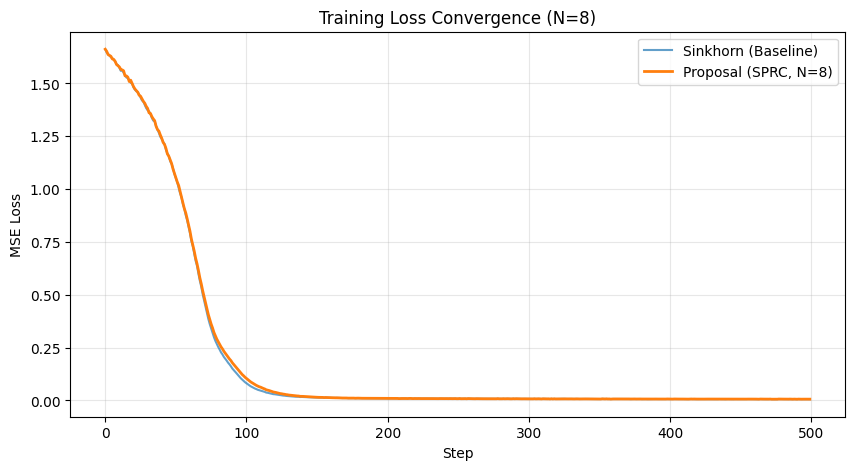

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import math
import numpy as np

# === 1. 実装（N次元汎用化・修正済み） ===

def stabilized_rational_chart(u, epsilon=1e-6, lambd=1.0, smoothness=1.0):
    """
    Stabilized Piecewise-Rational Chart (SPRC)
    任意の次元 N に対応 (入力次元が (N-1)^2 であれば自動判定)
    """
    B = u.shape[0]
    dim_u = u.shape[-1]

    # 1. 次元 N の自動判定
    # u のサイズは (N-1)^2 なので、平方根をとって N を逆算
    m = int(math.sqrt(dim_u)) # m = N - 1
    n = m + 1

    if m * m != dim_u:
        raise ValueError(f"Input dimension {dim_u} is not a perfect square. It must be (N-1)^2.")

    # 2. Tangent Space Projection (N次元対応)
    # R^{(N-1)^2} -> R^(NxN) (行和・列和が0)

    u_core = u.view(B, m, m)

    row_sum = u_core.sum(dim=2) # (B, m)
    col_sum = u_core.sum(dim=1) # (B, m)
    total_sum = row_sum.sum(dim=1, keepdim=True) # (B, 1)

    # パディングを使って V を構築 (torch.cat地獄の解消)
    V = torch.zeros(B, n, n, device=u.device, dtype=u.dtype)

    V[:, :m, :m] = u_core
    V[:, :m, m] = -row_sum
    V[:, m, :m] = -col_sum
    V[:, m, m] = total_sum.squeeze(-1)

    # 3. Smooth Tropical Norm (境界までの距離)
    # LogSumExp(-V) を使用して滑らかに近似
    neg_V = -V
    m_V_smooth = smoothness * torch.logsumexp(neg_V.view(B, -1) / smoothness, dim=1).view(B, 1, 1)

    # 4. Progressive Saturation (中心付近の勾配消失を防ぐ)
    V_norm = torch.norm(V.view(B, -1), p=2, dim=1).view(B, 1, 1)
    saturation = torch.tanh(lambd * V_norm)

    # 5. Construct H
    # 中心点 J_N (要素はすべて 1/N)
    J_val = 1.0 / n

    # スケーリング係数
    scale = (J_val * saturation) / (m_V_smooth + epsilon)

    H = J_val + scale * V

    return H

def sinkhorn_knopp(u_raw, n_iters=20):
    # Baseline: 入力をexpして正規化を繰り返す
    # u_raw: (B, N, N)
    matrix = torch.exp(u_raw)
    for _ in range(n_iters):
        matrix = matrix / (matrix.sum(dim=2, keepdim=True) + 1e-6)
        matrix = matrix / (matrix.sum(dim=1, keepdim=True) + 1e-6)
    return matrix

# === 2. テスト用レイヤー定義 (N次元対応) ===

class ToyMHCLayer(nn.Module):
    def __init__(self, dim, n=4, method='proposal'):
        super().__init__()
        self.dim = dim
        self.n = n
        self.method = method

        # 整合性チェック
        if dim % n != 0:
            raise ValueError(f"Dimension {dim} must be divisible by n={n}")

        # パラメータ定義
        # SPRC (Proposal) は (N-1)^2 個の自由度
        # Sinkhorn は NxN 個の自由度を持つのが一般的
        if method == 'proposal':
            input_dim = (n - 1) ** 2
            self.param = nn.Parameter(torch.randn(1, input_dim) * 0.1)
        else:
            self.param = nn.Parameter(torch.randn(1, n, n) * 0.1)

        # ダミーの線形層 (学習対象)
        self.linear = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        # x: (B, Seq, Dim)
        B_size = x.size(0)

        # 接続行列 H を生成 (Batchサイズに合わせて拡張)
        if self.method == 'proposal':
            u_exp = self.param.expand(B_size, -1)
            H = stabilized_rational_chart(u_exp) # (B, n, n)
        else:
            u_exp = self.param.expand(B_size, -1, -1)
            H = sinkhorn_knopp(u_exp) # (B, n, n)

        # mHC的な混合操作 (一般化)
        chunk_dim = self.dim // self.n
        # (B, S, n, D/n) に分割
        x_split = x.view(B_size, -1, self.n, chunk_dim)

        H = H.unsqueeze(1) # (B, 1, n, n)

        # Einstein Summation: batch(b), seq(s), out_mix(i), in_mix(j), dim(d)
        x_mixed = torch.einsum('b s j d, b s i j -> b s i d', x_split, H)
        x_mixed = x_mixed.reshape(B_size, -1, self.dim)

        return self.norm(x_mixed + self.linear(x))

# === 3. 学習ループ (実験) ===

def run_training_experiment():
    print("=== Phase 3: Learning Dynamics Check (N-Dimensional) ===")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")

    # ここで N=8 に設定して「汎用性」をテストします！
    N_TEST = 8
    DIM = 256
    STEPS = 500
    BATCH = 64
    LR = 1e-3

    print(f"Testing with N = {N_TEST} (Input dim for SPRC: {(N_TEST-1)**2})")

    models = {
        'Sinkhorn': ToyMHCLayer(DIM, n=N_TEST, method='sinkhorn').to(device),
        'Proposal': ToyMHCLayer(DIM, n=N_TEST, method='proposal').to(device)
    }

    optimizers = {
        name: optim.AdamW(model.parameters(), lr=LR) for name, model in models.items()
    }

    history = {'Sinkhorn': [], 'Proposal': []}
    times = {'Sinkhorn': 0.0, 'Proposal': 0.0}

    print(f"{'Step':<6} | {'Sinkhorn Loss':<15} | {'Proposal Loss':<15}")
    print("-" * 45)

    for step in range(STEPS):
        # ランダムデータ生成
        x = torch.randn(BATCH, 16, DIM, device=device)
        target = x.clone() # 入力を復元するタスク (Identity Mapping)

        for name, model in models.items():
            t0 = time.time()

            optimizers[name].zero_grad()
            out = model(x)
            loss = F.mse_loss(out, target)
            loss.backward()
            optimizers[name].step()

            dt = time.time() - t0
            times[name] += dt
            history[name].append(loss.item())

            if name == 'Proposal' and step % 50 == 0:
                s_loss = history['Sinkhorn'][-1]
                p_loss = history['Proposal'][-1]
                print(f"{step:<6} | {s_loss:.6f}          | {p_loss:.6f}")

    print("-" * 45)
    print(f"Total Training Time (500 steps, N={N_TEST}):")
    print(f"  Sinkhorn: {times['Sinkhorn']:.2f} sec")
    print(f"  Proposal: {times['Proposal']:.2f} sec")
    ratio = times['Sinkhorn'] / times['Proposal'] if times['Proposal'] > 0 else 0
    print(f"  Ratio   : {ratio:.2f}x faster")

    # グラフ描画
    plt.figure(figsize=(10, 5))
    plt.plot(history['Sinkhorn'], label='Sinkhorn (Baseline)', alpha=0.7)
    plt.plot(history['Proposal'], label=f'Proposal (SPRC, N={N_TEST})', linewidth=2)
    plt.title(f'Training Loss Convergence (N={N_TEST})')
    plt.xlabel('Step')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    run_training_experiment()